So before we get underway with our fancy-pants *tuned* models to approximate our survival/hazard equations, it's worth highlighting a simple estimator that provides a useful, if naive, approximation with minimal headache.

This straight-forward equation is called the Kaplan-Meier Estimate and is used as a proxy for evaluating the Survival Function at a given point in time.

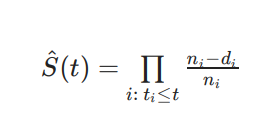

In [1]:
from IPython.display import Image
Image('images/km_eq.PNG')

The `n_i` term is the population still at risk right before time `i` (not yet swallowed by `F(t)`), and `d_i` is the number of events that occur *on* time `i`.

A couple things worth noting here:

* We use product, not sum, here in order to account for the joint probability of surviving at time `i`, as well as surviving through all times before
* This equation cleanly handles data that drops out due to an event obsevation or censoring. Similarly, it considers data with no established terminus for the duration of the obseration.

[This blog-post](https://towardsdatascience.com/survival-analysis-intuition-implementation-in-python-504fde4fcf8e) works through a toy example on six points of data.

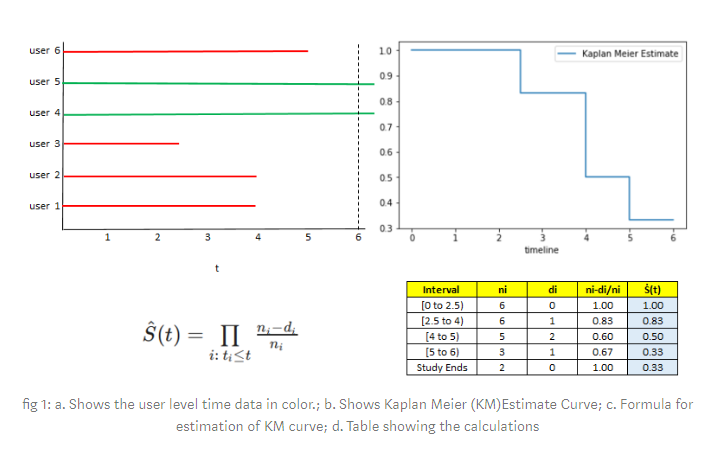

In [2]:
Image('images/km_simple.PNG')

## On Actual Data

At scale, these look a lot more sophisticated, and with hardly any additional effort.

Let's pull a dataset of term-lengths of Canadian Senators from the `lifelines` library.

In [3]:
%pylab inline

from lifelines.datasets import load_canadian_senators

data = load_canadian_senators()
data.head()

Populating the interactive namespace from numpy and matplotlib


,Name,Political Affiliation at Appointment,Province / Territory,Appointed on the advice of,Term (yyyy.mm.dd),start_date,end_date,reason,diff_days,observed
0,"Abbott, John Joseph Caldwell",Liberal-Conservative,Quebec,"Macdonald, John Alexander",1887.05.12 - 1893.10.30 (Death),1887-05-12 00:00:00,1893-10-30 00:00:00,Death,2363,True
1,"Adams, Michael",Conservative (1867-1942),New Brunswick,"Bowell, Mackenzie",1896.01.07 - 1899.01.01 (Death),1896-01-07 00:00:00,1899-01-01 00:00:00,Death,1090,True
2,"Adams, Willie",Liberal Party of Canada,Northwest Territories,"Trudeau, Pierre Elliott",1977.04.05 - 2009.06.22 (Retirement),1977-04-05 00:00:00,2009-06-22 00:00:00,Retirement,11766,True
3,"Aikins, James Cox",Liberal-Conservative,Ontario,Royal Proclamation,1867.10.23 - 1882.05.30 (Resignation),1867-10-23 00:00:00,1882-05-30 00:00:00,Resignation,5333,True
4,"Aikins, James Cox",Liberal-Conservative,Ontario,"Bowell, Mackenzie",1896.01.07 - 1904.08.06 (Death),1896-01-07 00:00:00,1904-08-06 00:00:00,Death,3133,True


There's a bit more information than we really need in this DataFrame, so we'll follow `lifelines` convention and stuff the durations and event observations into their own Series-- `T` and `E`, respectively

In [4]:
T = data['diff_days']
E = data['observed'].map({True: 1, False: 0})

Before we fit the Kaplan-Meier Estimator to the data, let's get a peek at some of the data.

There are a ton of records

In [5]:
len(data)

933

And after a bit of inspection, I found that there was a good mix of "observed" and "not observed" event data between 1000 and 2000 days. So we'll narrow down to that timeline window and sample down to 50 records, to make a neater lifetime plot.

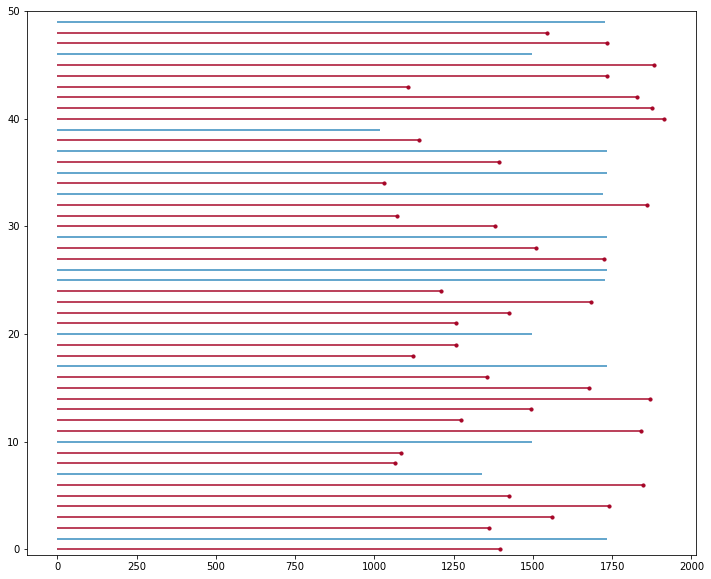

In [6]:
from lifelines.plotting import plot_lifetimes

narrowed = (data[(data['diff_days'] > 1000)
                  & (data['diff_days'] < 2000)]
           ).sample(n=50, random_state=0).reset_index()
narrowed_T = narrowed['diff_days']
narrowed_E = narrowed['observed']

fig, ax = plt.subplots(figsize=(12, 10))

plot_lifetimes(durations=narrowed_T,
               event_observed=narrowed_E);

### Fitting the Curve

Actually fitting the data is super easy.

While the `lifelines.fitters.BaseFitter` object doesn't directly inherit from anything in the `sklearn` space, the interface is more or less the same. We just need to specify the Series values that we want to use to fit `durations` and `event_observed`.

In [7]:
from lifelines import KaplanMeierFitter


kmf = KaplanMeierFitter()
kmf.fit(durations=T, event_observed=E)

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 933 total observations, 99 right-censored observations>

And the object even comes, batteries-included, with a neat plotting interface.

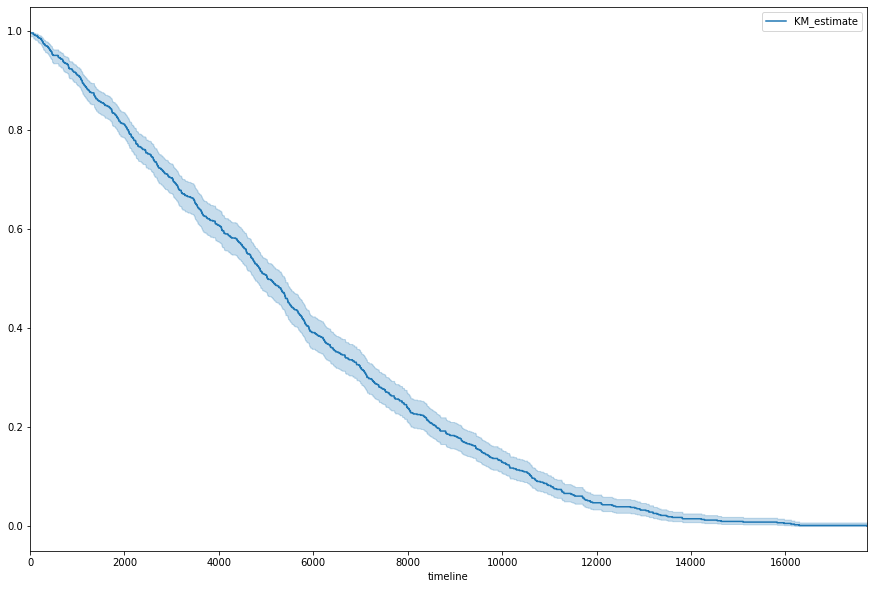

In [8]:
fig, ax = plt.subplots(figsize=(15, 10))

kmf.plot(ax=ax);

Where the lighter area around the curve represents the 95% Confidence Interval, achieved via the exponential Greenwood (says the `lifeline` docs).

Additionally, the model object gives us a bunch of other statistical goodies.

In [9]:
for fn in dir(kmf):
    if (fn[-1] == '_' and fn[0] != '_'):
        print(fn)

conditional_time_to_event_
confidence_interval_
confidence_interval_cumulative_density_
confidence_interval_survival_function_
cumulative_density_
median_survival_time_
survival_function_


### As an Analytical Tool

The Kaplan-Meier Estimator is obviously useful for getting a handle on the basic shape of the survival curve for your population. But with surprisingly-little adjustment, it also provides analytical insight between different segments of your population.

For instance, suppose we were interested in comparing the survival curves of sentators, based on which decade they were elected in. Getting at those values is simply some clever `pandas` datetime stuff on the field `start_date`, which reveals the decades for which we have the most data.

In [10]:
import pandas as pd

decade = pd.to_datetime(data['start_date']).dt.year // 10 * 10

decade.value_counts()

1990    85
1860    78
2000    76
1940    71
1970    67
1910    67
1960    65
1900    60
1950    51
1920    51
1930    49
1890    48
1880    47
1870    47
1980    41
2010    30
Name: start_date, dtype: int64

To better illustrate change over time, we'll space out which decades we grab from: 1860, 1940, 1990

Then, plotting them together simply involves making a shared plot, then fitting the same estimator and plotting the results-- three times.

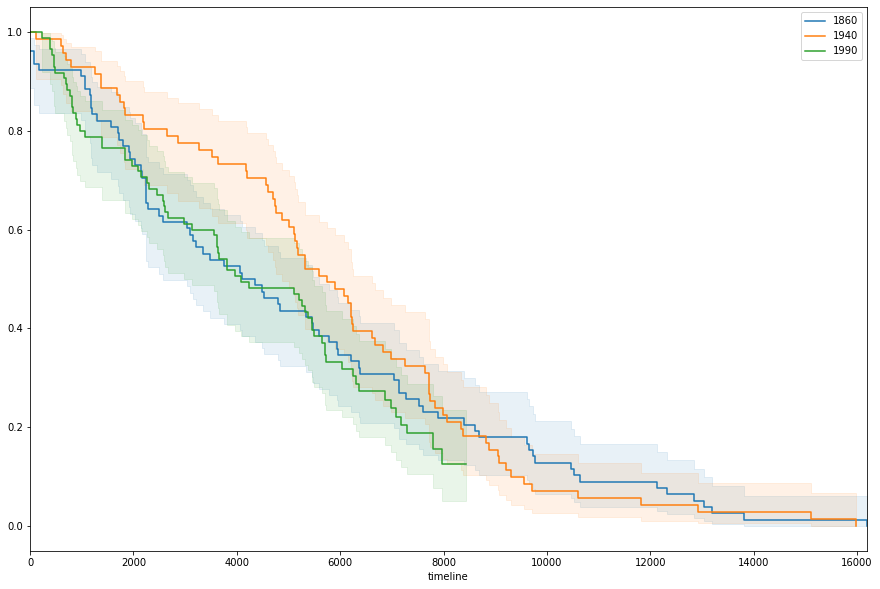

In [11]:
fig, ax = plt.subplots(figsize=(15, 10))

kmf = KaplanMeierFitter()
kmf.fit(T[decade==1860], E[decade==1860], label='1860')
kmf.plot(ax=ax, ci_alpha=.1)

kmf.fit(T[decade==1940], E[decade==1940], label='1940')
kmf.plot(ax=ax, ci_alpha=.1)

kmf.fit(T[decade==1990], E[decade==1990], label='1990')
kmf.plot(ax=ax, ci_alpha=.1);

And almost immediately, you'll notice that the senators elected in the 40s enjoyed a much kinder survival rate between days 3 and 5 thousand. However to better pick apart why this might be, we'd be better-served using other approaches.